# Markov Chain Monte Carlo Slope Fitting
This notebook performs MCMC simulations to fit linear relations to the data. We use the LinMix package developed by Kelly [2007].

Author: Iris Reitsma <br />

In [1]:
"""
Importing all libraries needed.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import linmix
from linmix.linmix import LinMix
import math

In [2]:
# Load in data
tbl = pd.read_csv('preprocessed_data_avg_30error.csv')
display(tbl.head())
# tbl = tbl[tbl['Filter']=='Ks'] # Select one band

,Unnamed: 0,Source,Filter,Obs_number,Detected Name,Date obs,RA,DEC,Error_circle (arcsec),Position_source,...,log_L_NIR_errup_nodist,log_L_NIR_errlow_nodist,log_L_NIR_errup_noflux,log_L_NIR_errlow_noflux,log_L_X_errup_nodist,log_L_X_errlow_nodist,log_L_X_errup_noflux,log_L_X_errlow_noflux,log_L_NIR_upplim,log_L_X_upplim
0,0,RX_J1735.3-3540,J,3081,S,2014-05-07,17 35 23.75,-35 40 16.1,0.56,"Israel+2008, UVOT",...,0.003808,0.003808,0.184256,0.184256,0.108574,0.108574,0.184256,0.184256,NaN,NaN
1,2,RX_J1735.3-3540,H,3063,S,2014-05-07,17 35 23.75,-35 40 16.1,0.56,"Israel+2008, UVOT",...,0.002848,0.002848,0.184256,0.184256,0.108574,0.108574,0.184256,0.184256,NaN,NaN
2,4,RX_J1735.3-3540,Ks,3045,S,2014-05-07,17 35 23.75,-35 40 16.1,0.56,"Israel+2008, UVOT",...,0.003019,0.003019,0.184256,0.184256,0.108574,0.108574,0.184256,0.184256,NaN,NaN
3,6,UW_Crb,Ks,1081,S,2018-06-19,16 05 45.8746697208,25 51 45.246497976,0.10,"Gaia Collaboration 2020, Gaia",...,0.051416,0.051416,0.184256,0.184256,0.130288,0.130288,0.184256,0.184256,NaN,NaN
4,7,UW_Crb,H,1086,S,2018-06-19,16 05 45.8746697208,25 51 45.246497976,0.10,"Gaia Collaboration 2020, Gaia",...,0.038230,0.038230,0.184256,0.184256,0.130288,0.130288,0.184256,0.184256,NaN,NaN


## Creating sample to perform fitting on

In [3]:
# Remove empty entries
valid = ~(np.isnan(tbl['L_X']) | np.isnan(tbl['L_NIR']))

# Determine error on luminosities
tbl['log_L_X_avgerr'] = (tbl['log_L_X_errlow'] + tbl['log_L_X_errup'])/2
tbl['log_L_NIR_avgerr'] = (tbl['log_L_NIR_errlow'] + tbl['log_L_NIR_errup'])/2                

In [4]:
# Remove 2 outliers
outliers = ['RX_J1735.3-3540', 'MAXI_J0556-332']
tbl = tbl.drop(tbl[tbl['Source'] == 'RX_J1735.3-3540'].index)
tbl = tbl.drop(tbl[tbl['Source'] == 'MAXI_J0556-332'].index)

# Remove source that was initially labelled active
tbl = tbl.drop(tbl[tbl['Source'] == 'XSS_J12270-4859'].index)

In [5]:
states = pd.read_csv('FSRED Mags - total_source_list.csv')

# Select which NSs and BHs to use (eg quiescent/active)
bhs = states[states['NS/BH']=='BH']['Source'].to_list()
BH_tbl = tbl[tbl['Source'].isin(bhs)]
# nss = states[(states['NS/BH']=='NS') | (states['NS/BH']=='NS ')| (states['NS/BH']=='NS (UC)')]['Source'].to_list()
nss = states[((states['NS/BH']=='NS') | (states['NS/BH']=='NS ')| (states['NS/BH']=='NS (UC)')) &  (states['Hard/soft state ']!='quiescence')]['Source'].to_list()
# nss = states[((states['NS/BH']=='NS') | (states['NS/BH']=='NS ')| (states['NS/BH']=='NS (UC)')) &  (states['Hard/soft state ']=='quiescence')]['Source'].to_list()
nss.append('XSS_J12270-4859')
NS_tbl = tbl[tbl['Source'].isin(nss)]

In [6]:

valid_ns = ~(np.isnan(NS_tbl['L_X']) | np.isnan(NS_tbl['L_NIR']))

x_ns = list(NS_tbl['log_L_X'][valid_ns])
y_ns = list(NS_tbl['log_L_NIR'][valid_ns])
xsig_ns = list(NS_tbl['log_L_X_avgerr'][valid_ns])
ysig_ns = list(NS_tbl['log_L_NIR_avgerr'][valid_ns])

for n, i in enumerate(xsig_ns):
    if math.isnan(i):
        xsig_ns[n] = 0.01 * x_ns[n]
for n, i in enumerate(ysig_ns):
    if math.isnan(i):
        ysig_ns[n] = 0.01 * y_ns[n]

valid_bh = ~(np.isnan(BH_tbl['L_X']) | np.isnan(BH_tbl['L_NIR']))

x_bh = list(BH_tbl['log_L_X'][valid_bh])
y_bh = list(BH_tbl['log_L_NIR'][valid_bh])
xsig_bh = list(BH_tbl['log_L_X_avgerr'][valid_bh])
ysig_bh = list(BH_tbl['log_L_NIR_avgerr'][valid_bh])

for n, i in enumerate(xsig_bh):
    if math.isnan(i):
        xsig_bh[n] = 0.01 * x_bh[n]
for n, i in enumerate(ysig_bh):
    if math.isnan(i):
        ysig_bh[n] = 0.01 * y_bh[n]

## Perform MCMC simulations

In [7]:
# Fits to BH sample
lm_bh = LinMix(x_bh, y_bh, xsig_bh, ysig_bh, K=2, seed=2)
lm_bh.run_mcmc(silent=False)


Iteration:  100
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.04868371 1.04430433 1.13354665 1.1345719  0.99596895 1.09918857]

Iteration:  200
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00122045 1.00055492 1.04581514 1.01874547 1.00129175 1.05851576]

Iteration:  300
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00151384 1.00175342 1.03631676 1.00816402 1.00244852 1.05235183]

Iteration:  400
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99919884 0.99930715 1.02670745 1.01356074 1.00601867 1.05475996]

Iteration:  500
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99844087 0.99840313 1.01934487 1.00957798 1.00474138 1.03242715]

Iteration:  600
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.9985647  0.99851767 1


Iteration:  4900
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00041962 1.00037722 1.00313263 0.99996172 1.00003621 1.00136721]

Iteration:  5000
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00039968 1.00035533 1.00229916 0.99992467 1.00010749 1.00124789]


In [8]:
# Fits to NS sample
lm_ns = LinMix(x_ns, y_ns, xsig_ns, ysig_ns, K=2, seed=2)
lm_ns.run_mcmc(silent=False)


Iteration:  100
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99034667 0.99036923 0.99689485 1.00454431 1.00257282 0.99524544]

Iteration:  200
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99631307 0.99616655 1.00366679 1.00030631 1.00030949 0.99891582]

Iteration:  300
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99730899 0.99728939 1.00229729 1.00219096 0.99868741 0.99929948]

Iteration:  400
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99831019 0.99820555 0.99824644 0.99905849 0.99895866 0.9989813 ]

Iteration:  500
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99944011 0.9993289  0.99854503 0.99880661 0.99916789 0.99895104]

Iteration:  600
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99988518 0.99978583 0


Iteration:  4800
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00040437 1.00040913 0.99993732 1.00019263 0.99999198 1.00009504]

Iteration:  4900
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00039389 1.00039846 0.99994958 1.00016931 0.99999198 1.00009192]

Iteration:  5000
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00038073 1.00038599 0.99996512 1.00011023 0.99999206 1.00006778]


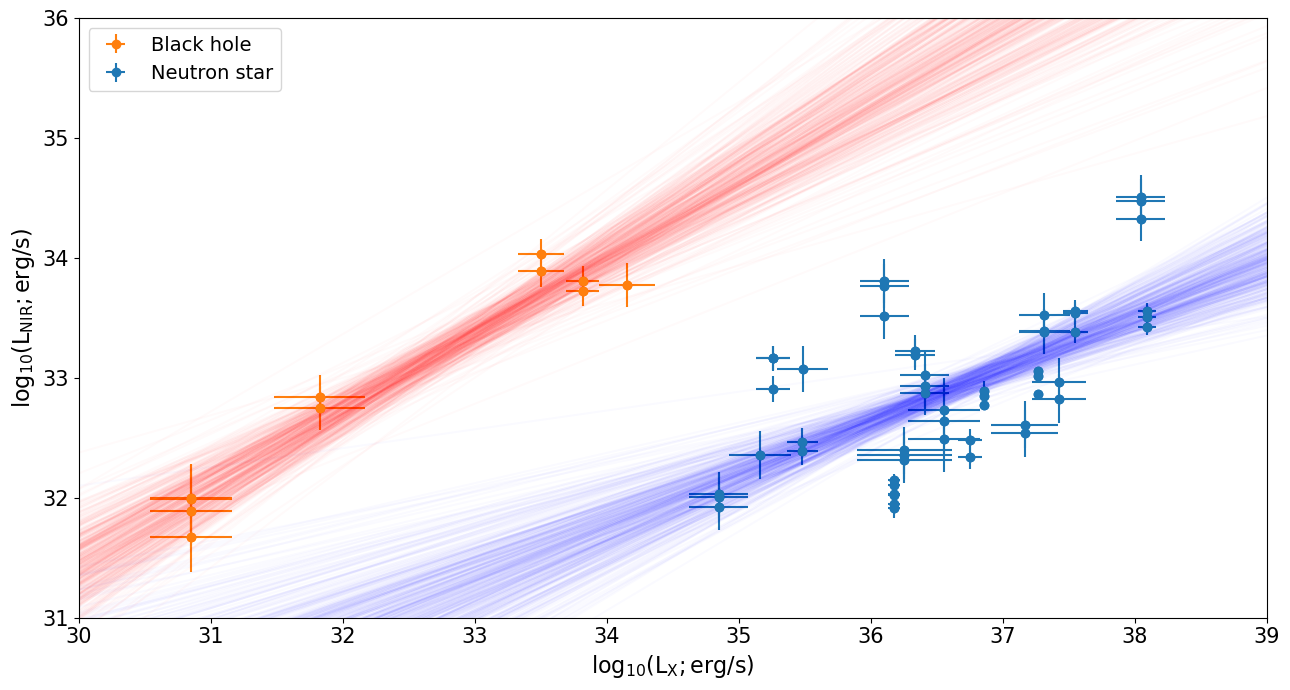

In [9]:
# Plot fit results
fig, ax = plt.subplots(figsize=(13,7))
ax.scatter(x_bh, y_bh, alpha=1, color='C1')
ax.errorbar(x_bh, y_bh, xerr=xsig_bh, yerr=ysig_bh, ls=' ', alpha=1, color='C1', label='Black hole',fmt='o')
ax.scatter(x_ns, y_ns, alpha=1)
ax.errorbar(x_ns, y_ns, xerr=xsig_ns, yerr=ysig_ns, ls=' ', alpha=1, label='Neutron star', fmt='o')
for i in range(0, len(lm_ns.chain), 25):
    xs = np.arange(30,41)
    ys = lm_ns.chain[i]['alpha'] + xs * lm_ns.chain[i]['beta']
    ax.plot(xs, ys, color='b', alpha=0.02)
for i in range(0, len(lm_bh.chain), 25):
    xs = np.arange(30,41)
    ys = lm_bh.chain[i]['alpha'] + xs * lm_bh.chain[i]['beta']
    ax.plot(xs, ys, color='r', alpha=0.02)
ax.set_xlabel(r'$\mathrm{log_{10}(L_{X}; erg/s)}$', fontsize=16)
ax.set_ylabel(r'$\mathrm{log_{10}(L_{NIR}; erg/s)}$', fontsize=16)
ax.set_xlim(30, 39)
ax.set_ylim(31, 36)
ax.tick_params(axis='both', labelsize=15)
fig.tight_layout()
ax.legend(fontsize=14)


## Print fitted slope + offset

In [10]:
print('For BH:')
print('slope: ', np.mean(lm_bh.chain['beta']), np.std(lm_bh.chain['beta']))
print('offset: ', np.mean(lm_bh.chain['alpha']), np.std(lm_bh.chain['alpha']))
print()
print('For NS:')
print('slope: ', np.mean(lm_ns.chain['beta']), np.std(lm_ns.chain['beta']))
print('offset: ', np.mean(lm_ns.chain['alpha']), np.std(lm_ns.chain['alpha']))

For BH:
slope:  0.6410365900448876 0.08931992660129154
offset:  12.21150142520955 2.9256434396356665

For NS:
slope:  0.4418455497024718 0.08410571172280541
offset:  16.727523787440497 3.078757147695643


## Plot posterior distributions

In [11]:
def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # No labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # Scatter plot:
    ax.scatter(x, y, s=0.1)
    factor = np.max(np.abs(x))/np.max(np.abs(y))
    print(factor)

    # Now determine nice limits by hand:
    binwidth = 0.25
    xlim = int(np.max(np.abs(x)/binwidth) + 1) * binwidth
    bins = np.arange(-1.3, 1.2 + binwidth, binwidth*factor)
    ax_histx.hist(x, bins=bins)
    ylim = int(np.max(np.abs(y)/binwidth) + 1) * binwidth
    bins = np.arange(-ylim, ylim + binwidth, binwidth)
    ax_histy.hist(y, bins=bins, orientation='horizontal')

0.025744867609958567
0.03991130433807515


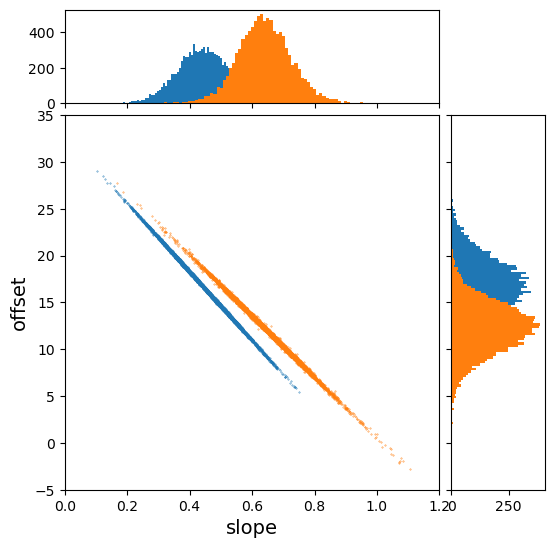

In [12]:
# Start with a square Figure.
fig = plt.figure(figsize=(6, 6))

# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

# Draw the scatter plot and marginals.
scatter_hist(lm_ns.chain['beta'], lm_ns.chain['alpha'], ax, ax_histx, ax_histy)
scatter_hist(lm_bh.chain['beta'], lm_bh.chain['alpha'], ax, ax_histx, ax_histy)
ax.set_xlabel('slope', fontsize=14)
ax.set_ylabel('offset', fontsize=14)
ax.set_ylim(-5, 35)
ax.set_xlim(0, 1.2)
plt.show()